# Forward modeling experiment

In [305]:
import numpy as np
import matplotlib.pyplot as plt
from pylops import FirstDerivative, Diagonal, VStack, Sum
from scipy.signal import filtfilt
import segyio
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import filtfilt
from pylops.utils.wavelets import *
from pylops.avo.poststack import *
from matplotlib.colorbar import Colorbar
import matplotlib.gridspec as gridspec
import warnings


In [222]:
# Create a 2D array of zeros
# Dimensions
nt = 2
nx = 50
nz = 50
m0 = np.zeros((nx, nz))
center_x, center_y = m0.shape[0] // 2, m0.shape[1] // 2

# Create a meshgrid of coordinates
x, y = np.meshgrid(np.arange(m0.shape[1]), np.arange(m0.shape[0]))

# Calculate the distance from each point to the center
dist = np.sqrt((x - center_x)**2 + (y - center_y)**2)

# Set the values inside the circle to 1
#m0[dist < 5] = 1
m0[20:30, 20:30] = 1


In [223]:
def plotter_4D(m1, m2, m3,  dt=1, type='impedance', perc=1,  height=4, width=15, cmap='seismic_r'):
    vmin, vmax = np.percentile(m1, [perc, 100 - perc])

    fig = plt.figure(figsize=(width, height))
    if type == 'seismic':
        gs = gridspec.GridSpec(5, 4, width_ratios=(1, 1, 1, .05), height_ratios=(.1, .5, .5, .5, .1),
                               left=0.1, right=0.9, bottom=0.1, top=0.9,
                               wspace=0.05, hspace=0.05)
        ax0 = fig.add_subplot(gs[:, 0])
        base = ax0.imshow(m1, vmin=-vmax, vmax=vmax, cmap=cmap, extent=[0, m1.shape[1], m1.shape[0] * dt, 0])
        ax0.set_ylabel('TWT $[s]$')
        ax0.set_title('a) data 1')
        ax0.axis('tight');
        ax1 = fig.add_subplot(gs[:, 1])
        ax1.imshow(m2, vmin=-vmax, vmax=vmax, cmap=cmap)
        ax1.set_yticklabels([])
        ax1.set_title('b) data 2')
        ax1.axis('tight');
        ax2 = fig.add_subplot(gs[:, 2])
        ax2.imshow(m3, vmin=-vmax, vmax=vmax, cmap=cmap)
        ax2.set_yticklabels([])
        ax2.set_title('c) data 3')
        ax2.axis('tight')
        ax3 = fig.add_subplot(gs[3:, 3])
        ax3.set_title('Amplitude', loc='left')
        Colorbar(ax=ax3, mappable=base)

    if type == 'impedance':
        gs = gridspec.GridSpec(5, 4, width_ratios=(1, 1, 1, .05), height_ratios=(.1, .5, .3, .5, .1),
                               left=0.1, right=0.9, bottom=0.1, top=0.9,
                               wspace=0.05, hspace=0.05)
        ax0 = fig.add_subplot(gs[:, 0])
        base = ax0.imshow(m1, vmin=vmin, vmax=vmax, cmap='terrain', extent=[0, m1.shape[1], m1.shape[0] * dt, 0])
        ax0.set_ylabel('TWT $[s]$')
        ax0.set_title('a) model 1')
        ax0.axis('tight');
        ax1 = fig.add_subplot(gs[:, 1])
        ax1.imshow(m2, vmin=vmin, vmax=vmax, cmap='terrain')
        ax1.set_yticklabels([])
        ax1.set_title('b) model 2')
        ax1.axis('tight');
        ax2 = fig.add_subplot(gs[:, 2])
        ax2.imshow(m3,  vmin=vmin, vmax=vmax, cmap='terrain')
        ax2.set_yticklabels([])
        ax2.set_title('c) model 3')
        ax2.axis('tight')
        ax3 = fig.add_subplot(gs[3:, 3])
        ax3.set_title('Impedance \n $[m/s*g/cm^3]$', loc='left')
        Colorbar(ax=ax3, mappable=base)


In [306]:
mt0, mt1 = [np.load(f'./Data/Forward/m{n}.npy') for n in range(2)]
dt0, dt1 = [np.load(f'./Data/Forward/d{n}.npy') for n in range(2)]
dnt0, dnt1 = [np.load(f'./Data/Forward/dn{n}.npy') for n in range(2)]


wedge = mt0-mt1
wedge = np.where(wedge >= 10e-1, 1500, 0)
nx, nz = wedge.shape

In [307]:
# Parameters
deltax = 1
deltaz = 1
deltat = 1

# Flatten the model tensor
wedge_flat = wedge.reshape(nx * nz, 1)

# Create the velocity field
vx = np.ones((nx * nz, 1))/10
vz = np.ones((nx * nz, 1))/10

# Create the spatial derivative operators
Ax = FirstDerivative((nx , nz), axis=0, sampling=deltax, edge=True, kind='centered', order=5)
Az = FirstDerivative((nx , nz), axis=1, sampling=deltaz, edge=True, kind='centered', order=5)

Am1 = Diagonal(vx) * Ax + Diagonal(vz) * Az

wedge1_flat = wedge_flat - Am1 * wedge_flat
wedge2_flat = wedge1_flat - Am1 * wedge1_flat

In [308]:
movedown1 = 20
movedown2 = 30

wedge1 = np.delete(wedge, range(-1, -movedown1-1, -1), 0)
wedge1 = np.vstack([np.zeros((movedown1, wedge.shape[1])), wedge1])

wedge2 = np.delete(wedge1, range(-1, -movedown2-1, -1), 0)
wedge2 = np.vstack([np.zeros((movedown2, wedge.shape[1])), wedge2])

wedge2 = np.delete(wedge2, range(0, 51, 1), 1)
wedge2 = np.hstack([wedge2, np.zeros((wedge.shape[0], 51))])

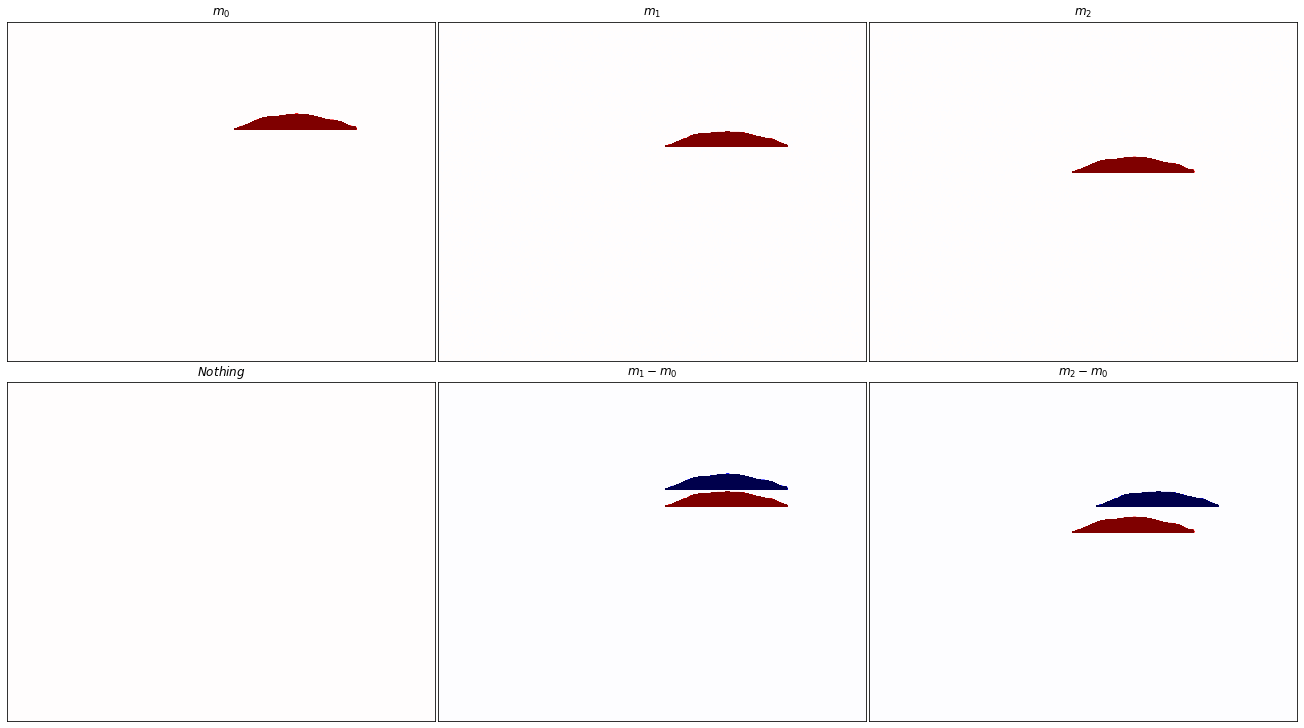

In [309]:
# wedge1 = wedge1_flat.reshape(nx, nz)
# wedge2 = wedge2_flat.reshape(nx, nz)

fig, axs = plt.subplots(2, 3, figsize=(18, 10))

axs[0, 0].imshow(wedge, cmap='seismic', vmin=-100, vmax=100, aspect='auto')
axs[0, 1].imshow(wedge1, cmap='seismic', vmin=-100, vmax=100, aspect='auto')
axs[0, 2].imshow(wedge2, cmap='seismic', vmin=-100, vmax=100, aspect='auto')

axs[1, 0].imshow(np.zeros((nx, nz)), cmap='seismic', vmin=-100, vmax=100, aspect='auto')
axs[1, 1].imshow(wedge1-wedge, cmap='seismic', vmin=-100, vmax=100, aspect='auto')
axs[1, 2].imshow(wedge2-wedge1, cmap='seismic', vmin=-100, vmax=100, aspect='auto')

axs[0, 0].set(xticks=[], yticks=[], title='$m_0$')
axs[0, 1].set(xticks=[], yticks=[], title='$m_1$')
axs[0, 2].set(xticks=[], yticks=[], title='$m_2$');

axs[1, 0].set(xticks=[], yticks=[], title='$Nothing$')
axs[1, 1].set(xticks=[], yticks=[], title='$m_1-m_0$')
axs[1, 2].set(xticks=[], yticks=[], title='$m_2 - m_0$');
plt.tight_layout(pad=0.3)


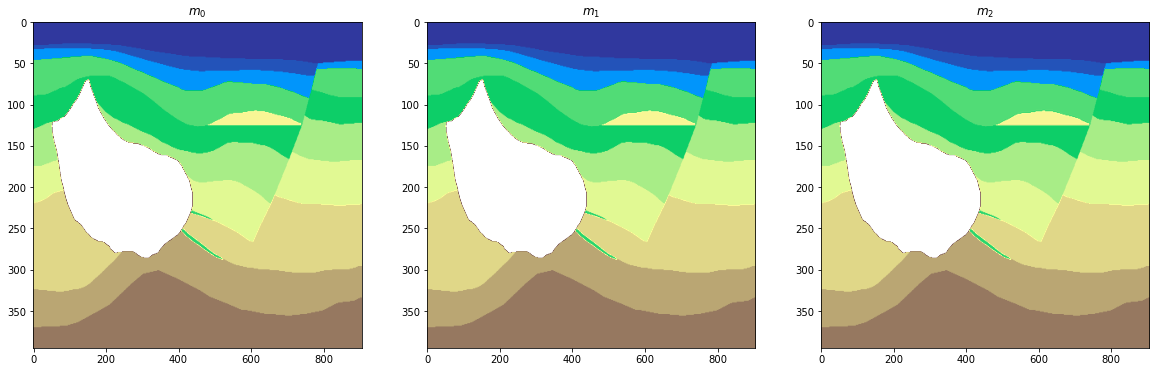

In [231]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].imshow(mt0 + wedge, cmap='terrain', vmin=3000, vmax=9000, aspect='auto')
axs[1].imshow(mt0 + wedge1, cmap='terrain', vmin=3000, vmax=9000, aspect='auto')
s=axs[2].imshow(mt0 + wedge2, cmap='terrain', vmin=3000, vmax=9000, aspect='auto')

axs[0].set(title='$m_0$');
axs[1].set(title='$m_1$');
axs[2].set(title='$m_2$');

In [310]:
# Creating Synthetic Seismic data
mf0 = wedge
mf1 = wedge1
mf2 = wedge2

nt0, nx = m1.shape
dt0 = 0.008
t0 = np.arange(nt0) * dt0

# Wavelet
ntwav = 61
wav, twav, wavc = ricker(t0[:ntwav // 2 + 1], 8)

# Operator
Lop = PoststackLinearModelling(wav / 2, nt0=nt0, spatdims=nx)

# data 1
#d0 = Lop * np.log(mf0.ravel())
d0 = Lop * mf0.ravel()

d0 = d0.reshape(nt0, nx)
sigman = 1e-1
n1 = filtfilt(np.ones(10) / 10, 1,
              filtfilt(np.ones(5) / 5, 1, np.random.normal(0, sigman, (nt0, nx)).T, method='gust').T,
              method='gust').ravel()
dn0 = d0 + n1.reshape(nt0, nx)*700

# data 2
# d1 = Lop * np.log(mf1.ravel())
d1 = Lop * mf1.ravel()
d1 = d1.reshape(nt0, nx)
sigman = 1e-1
n2 = filtfilt(np.ones(10) / 10, 1,
              filtfilt(np.ones(5) / 5, 1, np.random.normal(0, sigman, (nt0, nx)).T, method='gust').T,
              method='gust').ravel()
dn1 = d1 + n2.reshape(nt0, nx)*700

# data 3
# d2 = Lop * np.log(mf2.ravel())
d2 = Lop * mf2.ravel()
d2 = d2.reshape(nt0, nx)
sigman = 1e-1
n3 = filtfilt(np.ones(10) / 10, 1,
             filtfilt(np.ones(5) / 5, 1, np.random.normal(0, sigman, (nt0, nx)).T, method='gust').T,
             method='gust').ravel()
dn2 = d2 + n3.reshape(nt0, nx)*700

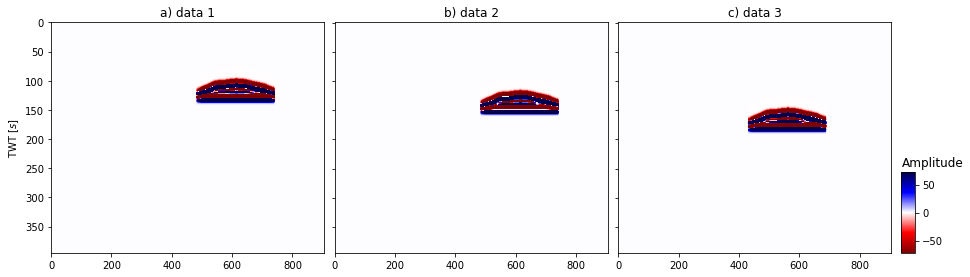

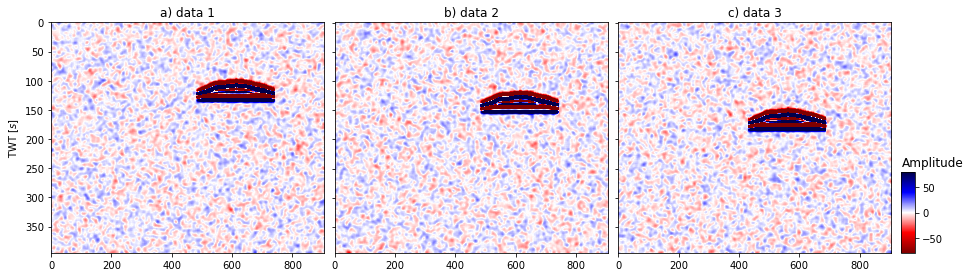

In [311]:
plotter_4D(d0, d1, d2, type='seismic')
plotter_4D(dn0, dn1, dn2, type='seismic')

In [312]:
for n in range(3):
    np.save(f'./Data/Forward_moving_wedge_less/m{n}.npy', [mf0, mf1, mf2][n])
    np.save(f'./Data/Forward_moving_wedge_less/d{n}.npy', [d0, d1, d2][n])
    np.save(f'./Data/Forward_moving_wedge_less/dn{n}.npy', [dn0, dn1, dn2][n])

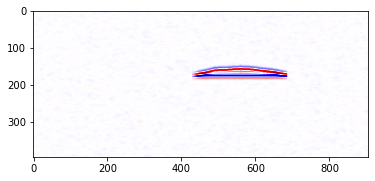

In [313]:
plt.imshow(dn2, cmap='seismic')